In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from ngsolve import *
from netgen.geom2d import unit_square


import numpy as np
import scipy
import math
import time
from math import pi

from ngsolve.webgui import Draw

class ReducedBasis:
    
    def __init__(self, fes, f):
        self.setSpace(fes, f)
        self.logging = True

In [ ]:
class ReducedBasis(ReducedBasis):
    
    def draw(self, omg, redraw=False):
        
        if self.__snapshots_updated:
            self.__computeRB()
        
        # compute reduced basis
        omega = (2*pi*40)/(np.sin(np.radians(omg)))
        ## TODO: make LU decomposition once  (for M and K) and use np.linalg.solve_triangular
        ## (vorwaerts- und rueckwaertssubstitution)
        if self.robin:
            print("Omega in if: ",omega,omg)
            Ainv = np.linalg.inv(self.K_red-omega*omega*self.M_red-omega*self.R_red)
        else:
            Ainv = np.linalg.inv(self.K_red-omega*omega*self.M_red)

        red_sol_vec = np.matmul(Ainv, self.F_red)
        
        self.drawu.vec.FV().NumPy()[:] = self.__V.dot(red_sol_vec)[:]
        #if self.logging: print("omega: {}, norm of solution: {}".format(omega, Integrate ( Conj(self.drawu)*(self.drawu), self.fes.mesh)))
        # draw solution
        if not redraw:
            #self.scene = Draw(self.drawu)
            self.scene = Draw(self.drawu,mesh,autoscale = False,min = -0.0001,max = 0.0001)
            print("draw")
        else:
            self.scene.Redraw()
            print("redraw")

In [6]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from ngsolve import *
from netgen.geom2d import unit_square


import numpy as np
import scipy
import math
import time
from math import pi

from ngsolve.webgui import Draw
from reduced_basis import *


In [7]:
def setang(alpha,d):
    if alpha > 90 or alpha < 30:
        return print("wrong angle")
    return d/(np.sin(np.radians(alpha)))

maxind = 20
mode = "equi"
s = 40

# set the minimumangle
alpha1 = 30
# set the maxangle
alpha2 = 70

lower = setang(alpha2,s)
upper = setang(alpha1,s)
omegfact = np.linspace(lower,upper,maxind)
snapshots = []
for i in range(maxind):
    snapshots.append(2*math.pi*omegfact[i])

In [15]:
from netgen.geom2d import *
import time

geo = SplineGeometry()

geo = SplineGeometry()
geo.AddRectangle ( (0,0), (1,1), bcs=["bottom","right","top","left"], leftdomain=1)

s = 40

r = 0.005
for i in range(s-1):
    geo.AddCircle ( (0.5,(i+1)/(s)), r=r, bc="interface", 
                     leftdomain=0, rightdomain=1)
geo.SetMaterial(1, "medium")


mesh = Mesh(geo.GenerateMesh(maxh=0.02))
mesh.Curve(3)
#Draw (mesh)

fes = H1(mesh, order=5, complex=True, dirichlet="interface")
n = { "medium" : 1, "dot" : 3 }
cfn = CoefficientFunction( [n[mat] for mat in mesh.GetMaterials()] )

source = 80*exp(-20**2*(y-0.5)*(y-0.5))
#Draw(source,mesh,name="sorce")

space = ReducedBasis(fes, source,cfn)
space.setSnapshots(snapshots)
#space1.setSnapshots(snapshots)
#interact(slider_func, ang=widgets.FloatSlider(min=alpha1, max=alpha2, step=1, value=alpha1))

#slider_func = lambda x: space.draw(x,mesh,redraw=True)
#space.draw(space.omega_min,mesh)
#interact(slider_func, x=widgets.FloatSlider(min=alpha1, max=alpha2, step=1, value=alpha1))

slider_func1 = lambda alpha: space.draw((2*pi*s)/(np.sin(np.radians(alpha))),redraw=True)
space.draw(space.omega_min,minval = -0.00007,maxval = 0.00007,autoscale = False)
interact(slider_func1, alpha=widgets.FloatSlider(min=alpha1, max=alpha2, step=1, value=alpha1))

set snapshots and reset basis
compute Reduced Basis
finished computing Reduced Basis
omega: 267.45704576991005, norm of solution: (1.5214099761115542e-07-4.943950697544178e-26j)


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2006-98-ge712f407', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

interactive(children=(FloatSlider(value=30.0, description='alpha', max=70.0, min=30.0, step=1.0), Output()), _…

<function __main__.<lambda>(alpha)>

 average residual: 1.3219840177782788e-05 
 amount of snapshots: 20


<IPython.core.display.Javascript object>


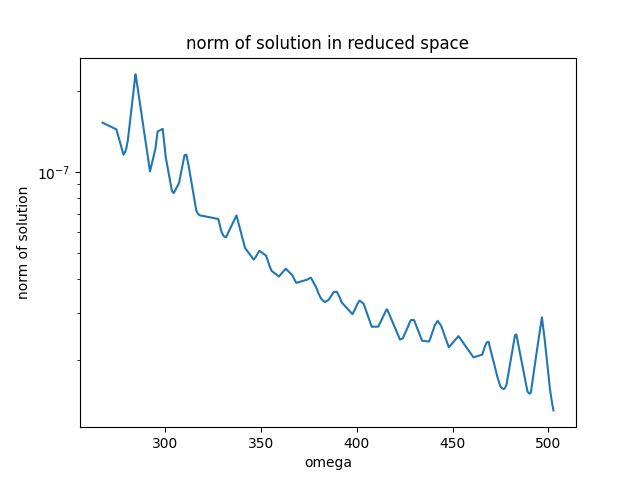

<IPython.core.display.Javascript object>


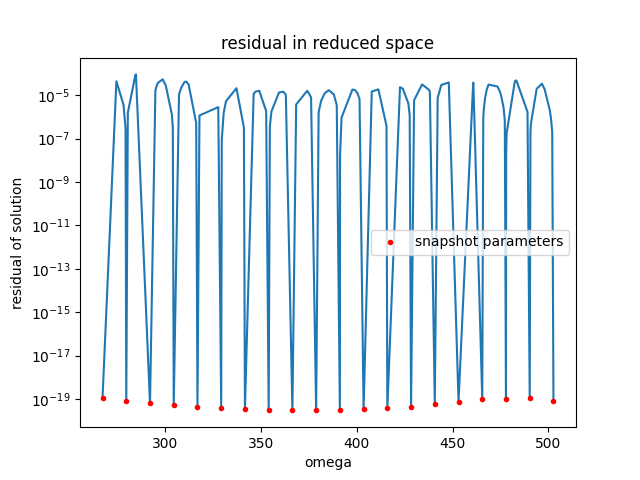

[]

In [16]:
random_omegas = np.sort(np.append(np.random.uniform(space.omega_min, space.omega_max, 100), snapshots))
%matplotlib notebook
import matplotlib.pyplot as plt

space.logging = False

norm_random_omegas, residual_random_omegas = space.computeValues(random_omegas, cheap = False)

print(" average residual: {} \n amount of snapshots: {}".format(np.mean(residual_random_omegas), len(space.getSnapshots())))

fig, ax = plt.subplots()
ax.plot(random_omegas, norm_random_omegas,  '-', label = "norm")
ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()

fig, ax = plt.subplots()         
ax.plot(random_omegas, residual_random_omegas , '-')
sn_residual = space.computeValues(space.getSnapshots(), norm= False, cheap = False)
ax.plot(space.getSnapshots(), sn_residual, 'r.', label = "snapshot parameters")
ax.legend()
ax.set_xlabel("omega")
ax.set_ylabel('residual of solution')
ax.set_title("residual in reduced space")
plt.semilogy()

In [ ]:
import time

space.logging = False
space.setSnapshots(snapshots, reset=True, compute_RB = True)

MAX_IT = 100
THRESHOLD = 1e-8

# initialize plot
fig_r = plt.figure()
ax_r = fig_r.add_subplot(111)
plt.ion()
fig_r.show()
fig_r.canvas.draw()

begin_time = time.time()

for i in range(MAX_IT):
        
    residual = space.computeValues(random_omegas, norm=False, cheap = False)
    
    ax_r.clear()    
    ax_r.plot(random_omegas, residual , '-')
    sn_residual = space.computeValues(space.getSnapshots(), norm = False, cheap = False)
    ax_r.plot(space.getSnapshots(), sn_residual, 'r.', label = 'snapshots')
    ax_r.set_xlabel('omega')
    ax_r.set_title('residual')
    plt.semilogy()
    
    
    if (max(residual) < THRESHOLD): 
        print("Finished after {} seconds".format(time.time()-begin_time))
        break
    
    # sort by residual (descending)
    zip_to_sort = list(zip(residual, range(len(residual))))
    sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=True)
    index = [tup[1] for tup in sorted_zip]
    
    for i in index:
        if not random_omegas[i] in space.getSnapshots(): 
            space.setSnapshots(random_omegas[i], reset=False, compute_RB = False)
            break
    
    ax_r.plot(random_omegas[i], residual[i], 'g*', label = 'snapshot to add')
    ax_r.legend()
    
    print("add snapshot for omega = {} average residual: {}".format(random_omegas[i], np.mean(residual)))

    
    fig_r.canvas.draw()
    space.computeValues(None,residual=False,  norm = False)

    
    time.sleep(0.00001)
    

print(" average residual: {} \n amount of snapshots: {}".format(np.mean(residual), len(space.getSnapshots())))